In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_jac_hvp_fun

import paragami
from vittles import solver_lib

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# np.random.seed(53453)

# load data

In [3]:
n_obs = 100
n_loci = 2000
n_pop = 4

In [4]:
data_file = '../simulated_data/simulated_structure_data_nobs{}_nloci{}_npop{}.npz'.format(n_obs, n_loci, n_pop)
data = np.load(data_file)

g_obs = np.array(data['g_obs'])

true_pop_allele_freq = np.array(data['true_pop_allele_freq'])
true_ind_admix_propn = np.array(data['true_ind_admix_propn'])

Text(0.5, 0, 'individual')

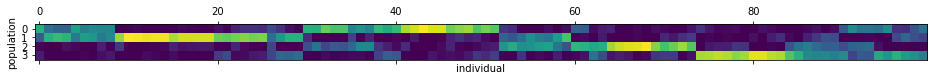

In [5]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [6]:
g_obs.shape

(100, 2000, 3)

# Load initial fit

In [7]:
alpha0 = 3.5

In [8]:
fit_dir = '../fits/fits_20200928/'

In [9]:
vb_params_dict, vb_params_paragami, meta_data = \
    paragami.load_folded(fit_dir + 'structure_fit_nobs{}_nloci{}_npop{}_alpha{}.npz'.format(n_obs, 
                                                                                          n_loci, 
                                                                                          n_pop, 
                                                                                          alpha0))

print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2000, 10, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (100, 9) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (100, 9) (lb=0.0001, ub=inf)


In [10]:
vb_opt_dict = deepcopy(vb_params_dict)
vb_opt = vb_params_paragami.flatten(vb_params_dict, free = True)

In [11]:
k_approx = vb_params_dict['pop_freq_beta_params'].shape[1]

In [12]:
gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)

use_logitnormal_sticks = meta_data['use_logitnormal_sticks'] == 1

# Get prior

In [13]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

prior_params_dict['dp_prior_alpha'] = np.array(meta_data['dp_prior_alpha'])
prior_params_dict['allele_prior_alpha'] = np.array(meta_data['allele_prior_alpha'])
prior_params_dict['allele_prior_beta'] = np.array(meta_data['allele_prior_beta'])

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.5], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


In [14]:
kl = structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                                gh_loc = gh_loc, gh_weights = gh_weights)

In [15]:
kl

DeviceArray(250236.49246163, dtype=float64)

In [16]:
# check KL's match
print(np.abs(kl - meta_data['final_kl']))
assert np.abs(kl - meta_data['final_kl']) < 1e-8

2.9103830456733704e-11


# Plot inferred cluster belongings

In [17]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

Text(0.5, 0, 'individual')

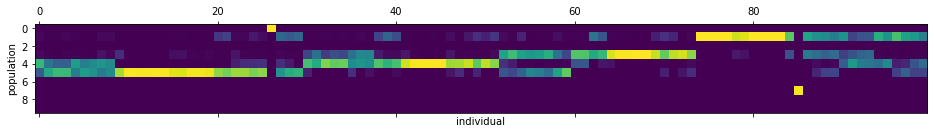

In [18]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

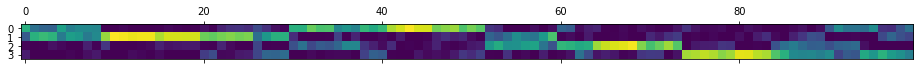

In [19]:
# truth
plt.matshow(true_ind_admix_propn.T)

# Define sensitivity object

In [20]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'], 
                                                              free = use_free_alpha)

In [21]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


### Get hessian solver

In [22]:
# define preconditioner
precon_fun = jax.jit(lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_info = True))
t0 = time.time()
_ = precon_fun(vb_opt)
print('preconditioner compile time: {:0.3}sec'.format(time.time() - t0))

preconditioner compile time: 0.637sec


In [23]:
M_op = osp.sparse.linalg.LinearOperator((len(vb_opt), len(vb_opt)), precon_fun)

# actual preconditioner time
%timeit M_op(vb_opt)

37.5 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
# get solver 
obj_fun_hvp = jax.jit(get_jac_hvp_fun(lambda x : objective_fun_free(x, prior_alpha0)))

cg_solver = solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, x), 
                                            dim = len(vb_opt), 
                                            cg_opts = {'M': M_op})


In [47]:
t0 = time.time()
obj_fun_hvp(vb_opt, vb_opt)
print(time.time() - t0)

0.0006341934204101562


In [37]:
# %timeit _ = obj_fun_hvp(vb_opt, vb_opt)

### Compute VB sensitivity derivatives

In [28]:
# for loading in an already saved hessian inverse solution ... 

class VBSensitivity(object): 
    def __init__(self, lr_file, opt_par_value, hyper_par_value0): 
        self.dinput_dhyper = np.load(lr_file)
        
        self.opt_par_value = opt_par_value
        self.hyper_par_value0 = hyper_par_value0
        
    def predict_opt_par_from_hyper_par(self, hyper_par_value):
        delta = (hyper_par_value - self.hyper_par_value0)

        if len(self.dinput_dhyper.shape) == 1:
            self.dinput_dhyper = np.expand_dims(self.dinput_dhyper, 1)

        return np.dot(self.dinput_dhyper, delta) + self.opt_par_value

In [29]:
load_lr_der = True
if load_lr_der: 
    lr_file = fit_dir + 'lr_nobs{}_nloci{}_npop{}_alpha{}.npy'.format(n_obs, 
                                                                          n_loci, 
                                                                          n_pop, 
                                                                          alpha0)
    vb_sens = VBSensitivity(lr_file, vb_opt, prior_alpha0)
else: 
    vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                            vb_opt,
                                                            prior_alpha0, 
                                                            hess_solver = cg_solver)



In [30]:
vb_sens.dinput_dhyper.shape

(41800,)

In [31]:
vb_opt.shape

(41800,)

# Load results from a range of alpha

In [32]:
alpha_list = np.arange(1, 10)

In [33]:
print('alphas: ', alpha_list)

alphas:  [1 2 3 4 5 6 7 8 9]


In [34]:
vb_pert_list = []
for alpha in alpha_list: 
    
    fit_file = '../fits/fits_20200928/structure_fit_nobs{}_nloci{}_npop{}_alpha{:.1f}.npz'.format(n_obs, 
                                                                                      n_loci, 
                                                                                      n_pop, 
                                                                                      alpha)
    
    print('loading results from: ', fit_file)
    
    vb_params_dict, _, meta_data = paragami.load_folded(fit_file)
    
    # check KL's match 
    assert np.abs(objective_fun(vb_params_dict, 
                                meta_data['dp_prior_alpha']) - \
                  meta_data['final_kl']) < 1e-8
    
    vb_pert_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))

loading results from:  ../fits/fits_20200928/structure_fit_nobs100_nloci2000_npop4_alpha1.0.npz
loading results from:  ../fits/fits_20200928/structure_fit_nobs100_nloci2000_npop4_alpha2.0.npz
loading results from:  ../fits/fits_20200928/structure_fit_nobs100_nloci2000_npop4_alpha3.0.npz
loading results from:  ../fits/fits_20200928/structure_fit_nobs100_nloci2000_npop4_alpha4.0.npz
loading results from:  ../fits/fits_20200928/structure_fit_nobs100_nloci2000_npop4_alpha5.0.npz
loading results from:  ../fits/fits_20200928/structure_fit_nobs100_nloci2000_npop4_alpha6.0.npz
loading results from:  ../fits/fits_20200928/structure_fit_nobs100_nloci2000_npop4_alpha7.0.npz
loading results from:  ../fits/fits_20200928/structure_fit_nobs100_nloci2000_npop4_alpha8.0.npz
loading results from:  ../fits/fits_20200928/structure_fit_nobs100_nloci2000_npop4_alpha9.0.npz


# Check free parameters

In [35]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha)))


In [36]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


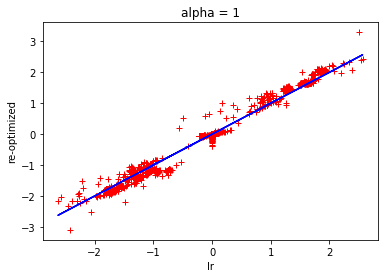

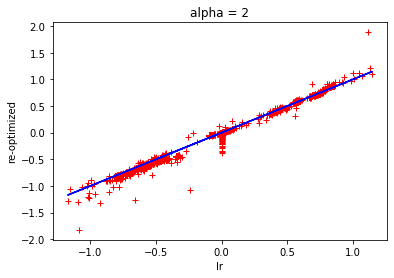

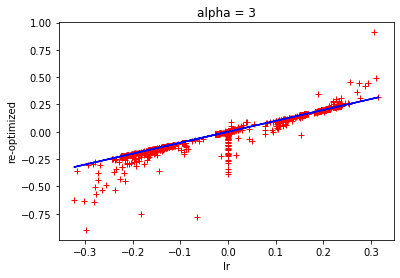

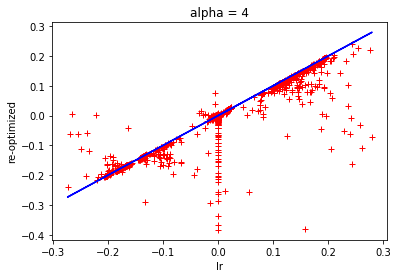

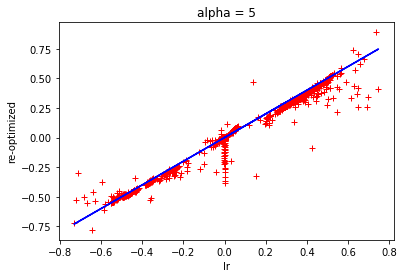

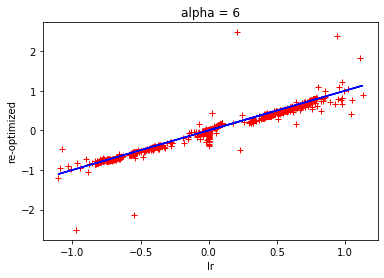

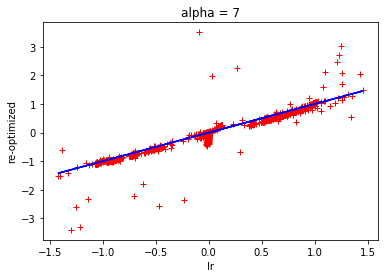

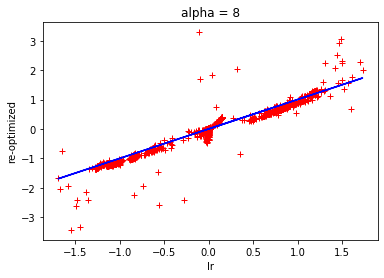

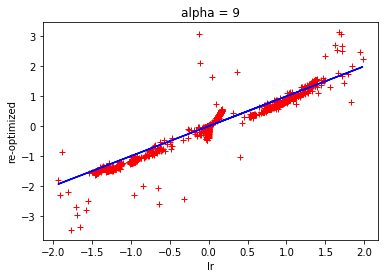

In [37]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


# Number of clusters

In [38]:
import numpy as onp

In [39]:
lr_e_num_clusters_vec = onp.zeros(len(alpha_list))
refit_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix, pert_e_pop_freq = get_vb_expectations(pert_dict, use_logitnormal_sticks)
    lr_e_ind_admix, lr_e_pop_freq = get_vb_expectations(lr_dict, use_logitnormal_sticks)
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


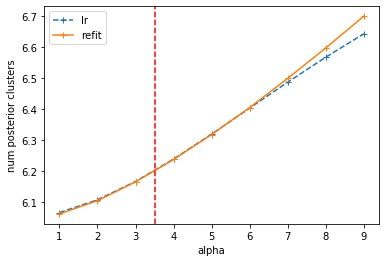

In [40]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['dp_prior_alpha'], color = 'red', linestyle = 'dashed')